# Calculating Prediction Error and exporting results

In [ ]:
def euclid_dist(pred_pts, gt_pts):
  """
  Calculate the euclidean distance between pairs of points
  :param pred_pts: The predicted points
  :param gt_pts: The ground truth points
  :return: An array of shape (no_points,) containing the distance of each predicted point from the ground truth
  """
  import numpy as np
  pred_pts = np.reshape(pred_pts, (-1, 2))
  gt_pts = np.reshape(gt_pts, (-1, 2))
  return np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1))


In [ ]:
def save_as_csv(points, location = '.'):
    """
    Save the points out as a .csv file
    :param points: numpy array of shape (no_test_images, no_points, 2) to be saved
    :param location: Directory to save results.csv in. Default to current working directory
    """
    assert points.shape[0]==554, 'wrong number of image points, should be 554 test images'
    assert np.prod(points.shape[1:])==2*42, 'wrong number of points provided. There should be 42 points with 2 values (x,y) per point'
    np.savetxt(location + '/results.csv', np.reshape(points, (points.shape[0], -1)), delimiter=',')


# Data Loading

In [ ]:
# Download the data stored in a zipped numpy array from one of these two locations
# The uncommented one is likely to be faster. If you're running all your experiments
# on a machine at home rather than using colab, then make sure you save it
# rather than repeatedly downloading it.

#!wget "http://users.sussex.ac.uk/~is321/training_images.npz" -O training_images.npz
!wget "https://sussex.box.com/shared/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz" -O training_images.npz

# The test images (without points)
#!wget "http://users.sussex.ac.uk/~is321/test_images.npz" -O test_images.npz
!wget "https://sussex.box.com/shared/static/xxlgvjpa86s6xgjzy5im06saoj57s7gt.npz" -O test_images.npz

# The example images are here
#!wget "http://users.sussex.ac.uk/~is321/examples.npz" -O examples.npz
!wget "https://sussex.box.com/shared/static/kbodelmaqw5dd59i5x2kis55lor7ydhf.npz" -O examples.npz



--2022-05-11 21:38:50--  https://sussex.box.com/shared/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz
Resolving sussex.box.com (sussex.box.com)... 103.116.4.197
Connecting to sussex.box.com (sussex.box.com)|103.116.4.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz [following]
--2022-05-11 21:38:50--  https://sussex.box.com/public/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz
Reusing existing connection to sussex.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sussex.app.box.com/public/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz [following]
--2022-05-11 21:38:51--  https://sussex.app.box.com/public/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz
Resolving sussex.app.box.com (sussex.app.box.com)... 107.152.24.201
Connecting to sussex.app.box.com (sussex.app.box.com)|107.152.24.201|:443... connected.
HTTP request sent, awaiting response... 302 Found
Locati

# Check the data downloaded correctly
If any of these assertions fail, redownload the data

In [ ]:
def confirm_checksum(filename, true_checksum):
  import subprocess
  checksum = subprocess.check_output(['shasum',filename]).decode('utf-8')
  assert checksum.split(' ')[0] == true_checksum, 'Checksum does not match for ' + filename + ' redownload the data.'

confirm_checksum('training_images.npz', 'f313a54fc57a1235e6307d176fc5fc83fd7ec530')
confirm_checksum('test_images.npz', '4b9efd8eb3b87c07d9c5400ef2494d476bc318a3')
confirm_checksum('examples.npz', 'bf51ebbf42f17e3cbe06bb299746565c53d16c40')

# Load the data

In [ ]:
import numpy as np


# Load the data using np.load
data = np.load('training_images.npz', allow_pickle=True)

# Extract the images
images = data['images']
# and the data points
pts = data['points']

print(images.shape, pts.shape)

test_data = np.load('test_images.npz', allow_pickle=True)
test_images = test_data['images']
print(test_images.shape)

examples = np.load('examples.npz', allow_pickle=True)
example_images = examples['images']
print(example_images.shape)

(2811, 244, 244, 3) (2811, 42, 2)
(554, 244, 244, 3)
(6, 244, 244, 3)


# Data Visualisation
Here's an example of how to display the images and their points

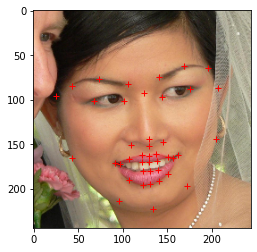

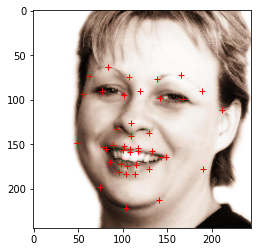

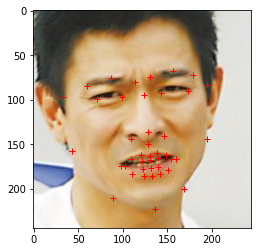

In [ ]:
import matplotlib.pyplot as plt
def visualise_pts(img, pts):
  import matplotlib.pyplot as plt
  plt.imshow(img,cmap = 'gray')
  plt.plot(pts[:, 0], pts[:, 1], '+r')
  plt.show()

for i in range(3):
  idx = np.random.randint(0, images.shape[0])
  visualise_pts(images[idx, ...], pts[idx, ...])

In [ ]:
#to show points of prediction and actual points on a picture
import matplotlib.pyplot as plt
def visualise_pts_and_pred(img, pts, pred):
  import matplotlib.pyplot as plt
  plt.imshow(img,cmap = "gray")
 # plt.ylim(min(pred[:,0]),max(pred[:,1]))
  #plt.xlim(min(pred[:,0]),max(pred[:,1]))
  plt.plot(pts[:, 0], pts[:, 1], 'dr')
  plt.plot(pred[:, 0], pred[:, 1], 'db')
  plt.show()



# Pre-processing


In [ ]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from skimage.transform import resize
#convert images to grayscale
images_gray = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in images])
examples_gray = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in example_images])
test_images_gray = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in test_images])
#split data into test and train data
x_train, x_test, y_train, y_test = train_test_split(images_gray, pts, test_size = 0.05)

print(len(x_test))
#resizing for hog
x_train_resize = np.array([resize(image,(128,64)) for image in x_train])
x_test_resize = np.array([resize(image,(128,64)) for image in x_test])
test_resize = np.array([resize(image,(128,64)) for image in test_images_gray])
examples_resize = np.array([resize(image,(128,64)) for image in examples_gray])

#using flattened images to train the linear regression model
x_train_flat = np.array([image.flatten() for image in x_train])
x_test_flat = np.array([image.flatten() for image in x_test])

test_flat = np.array([image.flatten() for image in test_images_gray])
examples_flat = np.array([image.flatten() for image in examples_gray])

y_train_flat = np.array([image.flatten() for image in y_train])
y_test_flat = np.array([image.flatten() for image in y_test])

#apply gaussian blur to images
blur = 5
x_train_edge_high_blur = np.array([cv2.GaussianBlur(image,(blur,blur),cv2.BORDER_CONSTANT) for image in x_train])
x_test_edge_high_blur = np.array([cv2.GaussianBlur(image,(blur,blur),cv2.BORDER_CONSTANT) for image in x_test])

test_edge_high_blur = np.array([cv2.GaussianBlur(image,(blur,blur),cv2.BORDER_CONSTANT) for image in test_images_gray])
examples_edge_high_blur = np.array([cv2.GaussianBlur(image,(blur,blur),cv2.BORDER_CONSTANT) for image in examples_gray])

x_train_edge_low_blur = np.array([cv2.GaussianBlur(image,(blur,blur),cv2.BORDER_CONSTANT) for image in x_train])
x_test_edge_low_blur = np.array([cv2.GaussianBlur(image,(blur,blur),cv2.BORDER_CONSTANT) for image in x_test])

test_edge_low_blur = np.array([cv2.GaussianBlur(image,(blur,blur),cv2.BORDER_CONSTANT) for image in test_images_gray])
examples_edge_low_blur = np.array([cv2.GaussianBlur(image,(blur,blur),cv2.BORDER_CONSTANT) for image in examples_gray])

#using canny edge detection
#high threshold
x_train_edge_high = np.array([cv2.Canny(image,75,100) for image in x_train_edge_high_blur])
x_test_edge_high = np.array([cv2.Canny(image,75,100) for image in x_test_edge_high_blur])

test_edge_high = np.array([cv2.Canny(image,75,100) for image in test_edge_high_blur])
examples_edge_high = np.array([cv2.Canny(image,75,100) for image in examples_edge_high_blur])

#train reshaping
nsamples, nx, ny = x_train_edge_high.shape
x_train_edge_high = x_train_edge_high.reshape((nsamples,nx*ny))
#test
nsamples, nx, ny = x_test_edge_high.shape
x_test_edge_high = x_test_edge_high.reshape((nsamples,nx*ny))

nsamples, nx, ny = test_edge_high.shape
test_edge_high = test_edge_high.reshape((nsamples,nx*ny))

nsamples, nx, ny = examples_edge_high.shape
examples_edge_high = examples_edge_high.reshape((nsamples,nx*ny))

#y train
nsamples, nx, ny = y_train.shape
y_train_edge_high = y_train.reshape((nsamples,nx*ny))

#low threshold
x_train_edge_low = np.array([cv2.Canny(image,50,75) for image in x_train_edge_low_blur])
x_test_edge_low = np.array([cv2.Canny(image,50,75) for image in x_test_edge_low_blur])

test_edge_low = np.array([cv2.Canny(image,50,75) for image in test_edge_low_blur])
examples_edge_low = np.array([cv2.Canny(image,50,75) for image in examples_edge_low_blur])

#train
nsamples, nx, ny = x_train_edge_low.shape
x_train_edge_low = x_train_edge_low.reshape((nsamples,nx*ny))
#test
nsamples, nx, ny = x_test_edge_low.shape
x_test_edge_low = x_test_edge_low.reshape((nsamples,nx*ny))

nsamples, nx, ny = test_edge_low.shape
test_edge_low = test_edge_low.reshape((nsamples,nx*ny))

nsamples, nx, ny = examples_edge_low.shape
examples_edge_low = examples_edge_low.reshape((nsamples,nx*ny))

#y test
nsamples, nx, ny = y_train.shape
y_train_edge_low = y_train.reshape((nsamples,nx*ny))

#using binary images fixed threshold
#blurring
x_train_binary_blur = np.array([cv2.medianBlur(image,5) for image in x_train])
x_test_binary_blur = np.array([cv2.medianBlur(image,5) for image in x_test])

test_binary_blur = np.array([cv2.medianBlur(image,5) for image in test_images_gray])
examples_binary_blur = np.array([cv2.medianBlur(image,5) for image in examples_gray])

x_train_binary = np.array([cv2.threshold(image,100,255,cv2.THRESH_BINARY)[1] for image in x_train_binary_blur])
x_test_binary = np.array([cv2.threshold(image,100,255,cv2.THRESH_BINARY)[1] for image in x_test_binary_blur])

test_binary = np.array([cv2.threshold(image,100,255,cv2.THRESH_BINARY)[1] for image in test_binary_blur])
examples_binary = np.array([cv2.threshold(image,100,255,cv2.THRESH_BINARY)[1] for image in examples_binary_blur])


#train
nsamples, nx, ny = x_train_binary.shape
x_train_binary = x_train_binary.reshape((nsamples,nx*ny))

nsamples, nx, ny = y_train.shape
y_train_binary = y_train.reshape((nsamples,nx*ny))
#test
nsamples, nx, ny = x_test_binary.shape
x_test_binary = x_test_binary.reshape((nsamples,nx*ny))
print(test_binary.shape)
nsamples, nx, ny = test_binary.shape
test_binary = test_binary.reshape((nsamples,nx*ny))

nsamples, nx, ny = examples_binary.shape
examples_binary = examples_binary.reshape((nsamples,nx*ny))

#using binary image with adaptive threshold
x_train_binary_blur_ad = np.array([cv2.medianBlur(image,5) for image in x_train])
x_test_binary_blur_ad = np.array([cv2.medianBlur(image,5) for image in x_test])

test_binary_blur_ad = np.array([cv2.medianBlur(image,5) for image in test_images_gray])
examples_binary_blur_ad = np.array([cv2.medianBlur(image,5) for image in examples_gray])

x_train_binary_ad = np.array([cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,3,2) for image in x_train_binary_blur_ad])
x_test_binary_ad = np.array([cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,3,2) for image in x_test_binary_blur_ad])

test_binary_ad = np.array([cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,3,2) for image in test_binary_blur_ad])
examples_binary_ad = np.array([cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,3,2) for image in examples_binary_blur_ad])
#train
nsamples, nx, ny = x_train_binary_ad.shape
x_train_binary_ad = x_train_binary_ad.reshape((nsamples,nx*ny))

nsamples, nx, ny = y_train.shape
y_train_binary_ad = y_train.reshape((nsamples,nx*ny))
#test
nsamples, nx, ny = x_test_binary_ad.shape
x_test_binary_ad = x_test_binary_ad.reshape((nsamples,nx*ny))

nsamples, nx, ny = test_binary_ad.shape
test_binary_ad = test_binary_ad.reshape((nsamples,nx*ny))

nsamples, nx, ny = examples_binary_ad.shape
examples_binary_ad = examples_binary_ad.reshape((nsamples,nx*ny))

141
(554, 244, 244)


In [ ]:
#hog feature detection
x_train_hog = np.array([hog(image,orientations = 9,pixels_per_cell = (8,8), cells_per_block = (2,2),visualize = False,multichannel = False) for image in x_train_resize])
x_test_hog = np.array([hog(image,orientations = 9,pixels_per_cell = (8,8), cells_per_block = (2,2),visualize = False,multichannel = False) for image in x_test_resize])
test_hog = np.array([hog(image,orientations = 9,pixels_per_cell = (8,8), cells_per_block = (2,2),visualize = False,multichannel = False) for image in test_resize])
examples_hog = np.array([hog(image,orientations = 9,pixels_per_cell = (8,8), cells_per_block = (2,2),visualize = False,multichannel = False) for image in examples_resize])

(<matplotlib.axes._subplots.AxesSubplot at 0x7f4bc1103a50>,
 <matplotlib.image.AxesImage at 0x7f4bc0bd9650>)

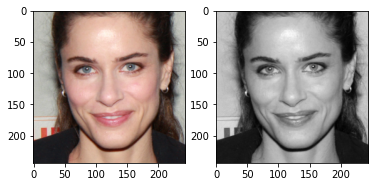

In [ ]:
plt.subplot(121),plt.imshow(images[0])
plt.subplot(122),plt.imshow(images_gray[0],cmap = 'gray')

(<matplotlib.axes._subplots.AxesSubplot at 0x7f4bc12fe090>,
 <matplotlib.image.AxesImage at 0x7f4bc0dd3b10>)

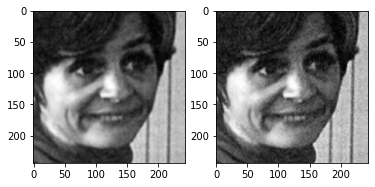

In [ ]:
plt.subplot(121),plt.imshow(x_train_edge_high_blur[9],cmap = 'gray')
plt.subplot(122),plt.imshow(x_train[9],cmap = 'gray')

# Hog

In [ ]:
from sklearn.linear_model import LinearRegression
#training a linear regression model for a adaptive binary set of images
model_hog = LinearRegression()

model_hog.fit(x_train_hog, y_train_flat)

LinearRegression()

In [ ]:
def hog_model_pred(img_index = 0):
  pred_edge = model_hog.predict(x_test_hog[img_index].reshape(1,-1))
  #visualise_pts_and_pred(x_test[img_index], y_test[img_index], pred_edge.reshape(42, 2))
  return pred_edge


list_of_pred_hog = np.array([hog_model_pred(x) for x in range(len(x_test))])
euc_dist_avg_all_hog = np.array([np.mean(euclid_dist(list_of_pred_hog[i].reshape(42, 2),y_test[i].reshape(42, 2))) for i in range(len(y_test))])

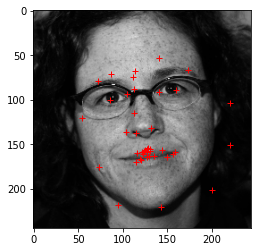

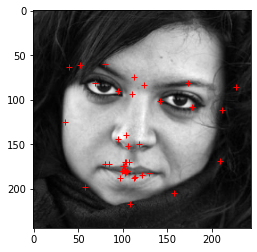

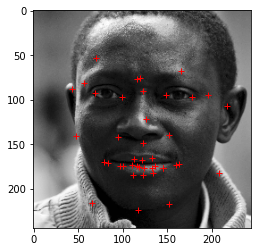

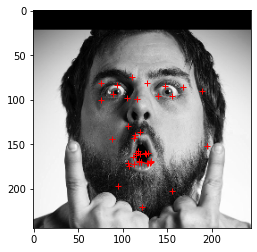

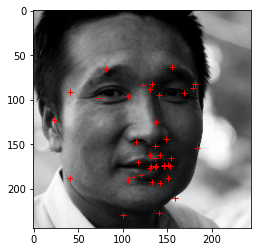

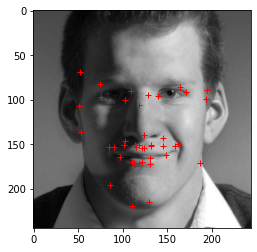

In [ ]:
def hog_model_pred_on_examples(img_index = 0):
  pred_edge = model_hog.predict(examples_hog[img_index].reshape(1,-1))
  #visualise_pts_and_pred(x_test[img_index], y_test[img_index], pred_edge.reshape(42, 2))


  return pred_edge

list_of_pred_hog_on_examples = np.array([hog_model_pred_on_examples(x) for x in range(len(examples_hog))])

for i in range(len(examples_hog)):
  visualise_pts(examples_gray[i],list_of_pred_hog_on_examples[i].reshape(42, 2))

[]

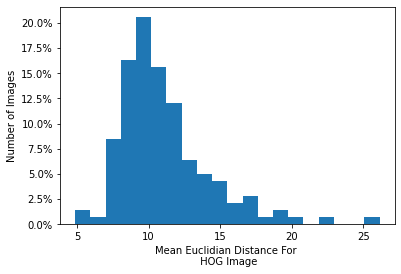

In [ ]:
#plotting all the edge euclidian distribution averages against their correspoinding image
from matplotlib.ticker import PercentFormatter
y = euc_dist_avg_all_hog
x = range(1, len(y)+1)
plt.ylabel("Number of Images")
plt.xlabel("Mean Euclidian Distance For \n HOG Image")
plt.hist(y,bins=20,weights=np.ones(len(y)) / len(y))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.plot()

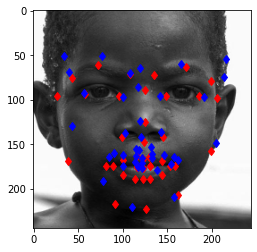

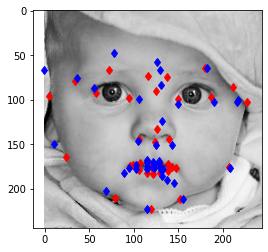

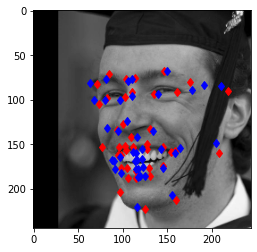

In [ ]:
#shows a sample of predictions for pictures.
for i in range(3):
  visualise_pts_and_pred(x_test[i],y_test[i], list_of_pred_hog[i].reshape(42, 2))

# Binary Image Adaptive

In [ ]:
from sklearn.linear_model import LinearRegression
#training a linear regression model for a adaptive binary set of images
model_binary_ad = LinearRegression()
print(x_train_binary_ad.shape, y_train_binary_ad.shape, y_train.shape, x_train.shape)



model_binary_ad.fit(x_train_binary_ad, y_train_binary_ad)

(2670, 59536) (2670, 84) (2670, 42, 2) (2670, 244, 244)


LinearRegression()

(<matplotlib.axes._subplots.AxesSubplot at 0x7f113aafddd0>,
 <matplotlib.image.AxesImage at 0x7f113aa6a350>)

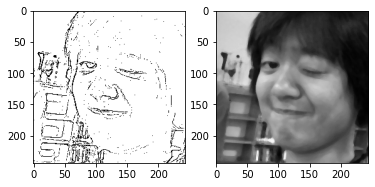

In [ ]:
plt.subplot(121),plt.imshow(x_train_binary_ad[0].reshape((244,244)),cmap = 'gray')
plt.subplot(122),plt.imshow(x_train_binary_blur_ad[0],cmap = 'gray')

In [ ]:
def binary_ad_model_pred(img_index = 0):
  pred_edge = model_binary_ad.predict(x_test_binary_ad[img_index].reshape(1,-1))
  #visualise_pts_and_pred(x_test[img_index], y_test[img_index], pred_edge.reshape(42, 2))
  return pred_edge


list_of_pred_binary_ad = np.array([binary_ad_model_pred(x) for x in range(len(x_test))])
euc_dist_avg_all_binary_ad = np.array([np.mean(euclid_dist(list_of_pred_binary_ad[i].reshape(42, 2),y_test[i].reshape(42, 2))) for i in range(len(y_test))])

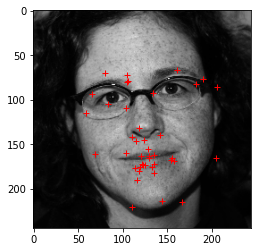

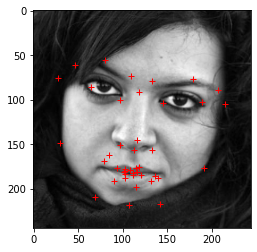

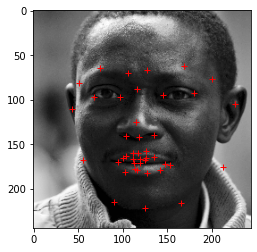

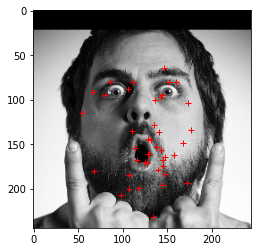

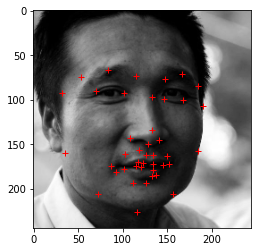

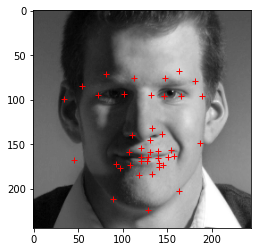

In [ ]:
def binary_ad_model_pred_on_examples(img_index = 0):
  pred_edge = model_binary_ad.predict(examples_binary_ad[img_index].reshape(1,-1))
  #visualise_pts_and_pred(x_test[img_index], y_test[img_index], pred_edge.reshape(42, 2))


  return pred_edge

list_of_pred_binary_ad_on_examples = np.array([binary_ad_model_pred_on_examples(x) for x in range(len(examples_binary_ad))])

for i in range(len(examples_binary_ad)):
  visualise_pts(examples_gray[i],list_of_pred_binary_ad_on_examples[i].reshape(42, 2))

In [ ]:
def binary_ad_model_pred_on_test(img_index = 0):
  pred_edge = model_binary_ad.predict(test_binary_ad[img_index].reshape(1,-1))
  return pred_edge

list_of_pred_binary_ad_on_test = np.array([binary_ad_model_pred_on_test(x) for x in range(len(test_images))])
save_as_csv(list_of_pred_binary_ad_on_test)

[]

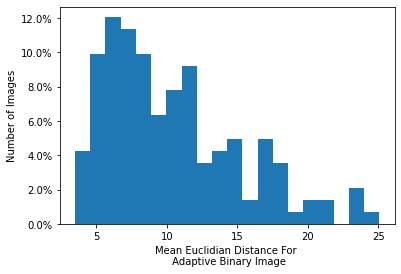

In [ ]:
#plotting all the edge euclidian distribution averages against their correspoinding image
from matplotlib.ticker import PercentFormatter
y = euc_dist_avg_all_binary_ad
x = range(1, len(y)+1)
plt.ylabel("Number of Images")
plt.xlabel("Mean Euclidian Distance For \n Adaptive Binary Image")
plt.hist(y,bins=20,weights=np.ones(len(y)) / len(y))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.plot()

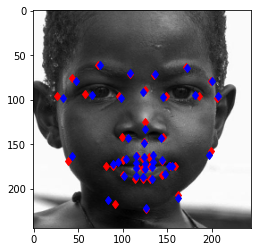

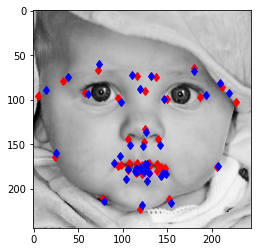

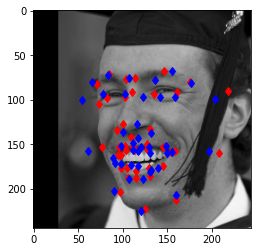

In [ ]:
#shows a sample of predictions for pictures.
for i in range(3):
  visualise_pts_and_pred(x_test[i],y_test[i], list_of_pred_binary_ad[i].reshape(42, 2))

# Binary Image Fixed Threshold


In [ ]:
from sklearn.linear_model import LinearRegression
#training a linear regression model for a binary set of images
model_binary = LinearRegression()
print(x_train_binary.shape, y_train_binary.shape, y_train.shape, x_train.shape)

model_binary.fit(x_train_binary, y_train_binary)

(2670, 59536) (2670, 84) (2670, 42, 2) (2670, 244, 244)


LinearRegression()

(<matplotlib.axes._subplots.AxesSubplot at 0x7f4bc0a31e90>,
 <matplotlib.image.AxesImage at 0x7f4bc10c7590>)

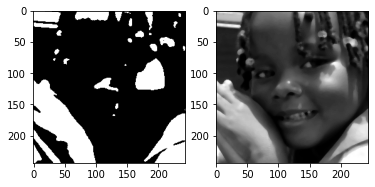

In [ ]:
plt.subplot(121),plt.imshow(x_train_binary[0].reshape((244,244)),cmap = 'gray')
plt.subplot(122),plt.imshow(x_train_binary_blur[0],cmap = 'gray')

In [ ]:
def binary_model_pred(img_index = 0):
  pred_edge = model_binary.predict(x_test_binary[img_index].reshape(1,-1))
  #visualise_pts_and_pred(x_test[img_index], y_test[img_index], pred_edge.reshape(42, 2))


  return pred_edge

list_of_pred_binary = [binary_model_pred(x) for x in range(len(x_test))]
euc_dist_avg_all_binary = [np.mean(euclid_dist(list_of_pred_binary[i].reshape(42, 2),y_test[i].reshape(42, 2))) for i in range(len(y_test))]

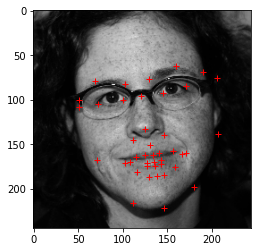

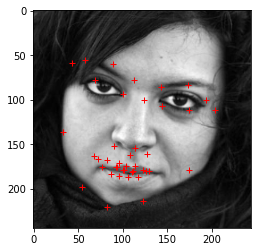

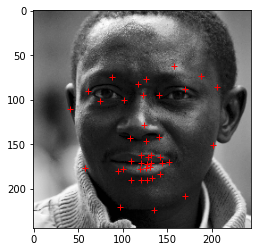

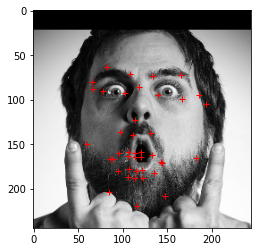

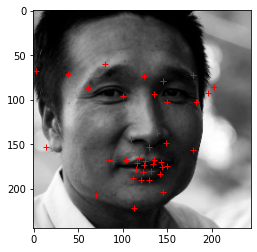

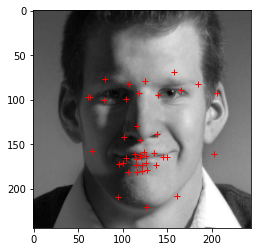

In [ ]:
def binary_model_pred_on_examples(img_index = 0):
  pred_edge = model_binary.predict(examples_binary[img_index].reshape(1,-1))
  #visualise_pts_and_pred(x_test[img_index], y_test[img_index], pred_edge.reshape(42, 2))


  return pred_edge

list_of_pred_binary_on_examples = np.array([binary_model_pred_on_examples(x) for x in range(len(examples_binary))])

for i in range(len(examples_binary)):
  visualise_pts(examples_gray[i],list_of_pred_binary_on_examples[i].reshape(42, 2))

[]

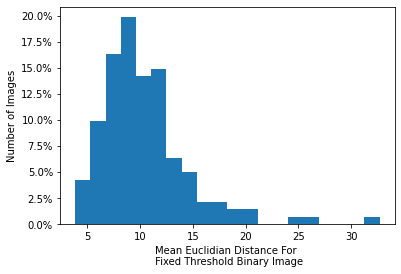

In [ ]:
#plotting all the edge euclidian distribution averages against their correspoinding image
from matplotlib.ticker import PercentFormatter
y = euc_dist_avg_all_binary
x = range(1, len(y)+1)
plt.ylabel("Number of Images")
plt.xlabel("Mean Euclidian Distance For \n Fixed Threshold Binary Image")
plt.hist(y,bins=20,weights=np.ones(len(y)) / len(y))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.plot()

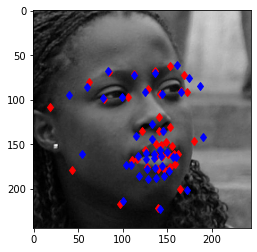

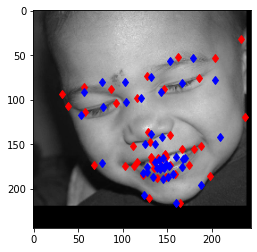

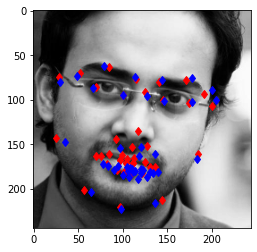

In [ ]:
#shows a sample of predictions for pictures.
for i in range(3):
  visualise_pts_and_pred(x_test[i],y_test[i], list_of_pred_binary[i].reshape(42, 2))

# Edge HIGH


In [ ]:
from sklearn.linear_model import LinearRegression
#training a linear regression model for a canny edge set of images at a high threshold
model_edge_high = LinearRegression()


model_edge_high.fit(x_train_edge_high,y_train_edge_high)

LinearRegression()

(<matplotlib.axes._subplots.AxesSubplot at 0x7f4bc07036d0>,
 <matplotlib.image.AxesImage at 0x7f4bc061a150>)

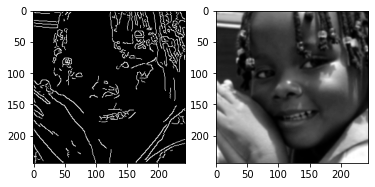

In [ ]:
plt.subplot(121),plt.imshow(x_train_edge_high[0].reshape((244,244)),cmap = 'gray')
plt.subplot(122),plt.imshow(x_train_edge_high_blur[0],cmap = 'gray')

In [ ]:
def edge_model_pred_high(img_index = 0):
  pred_edge = model_edge_high.predict(x_test_edge_high[img_index].reshape(1,-1))
  #visualise_pts_and_pred(x_test[img_index], y_test[img_index], pred_edge.reshape(42, 2))


  return pred_edge

list_of_pred_edge_high = [edge_model_pred_high(x) for x in range(len(x_test))]
euc_dist_avg_all_edge_high = [np.mean(euclid_dist(list_of_pred_edge_high[i].reshape(42, 2),y_test[i].reshape(42, 2))) for i in range(len(y_test))]



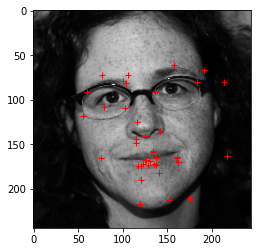

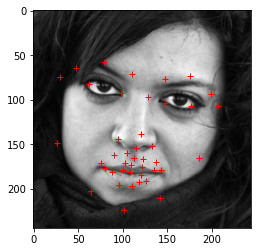

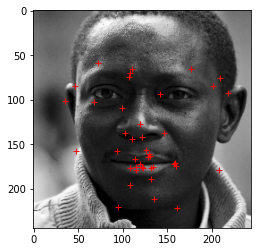

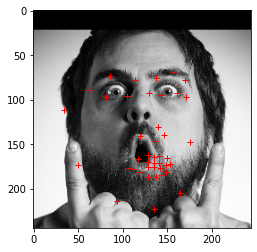

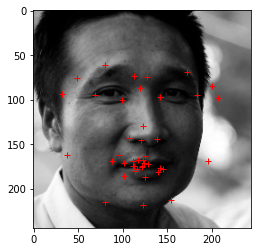

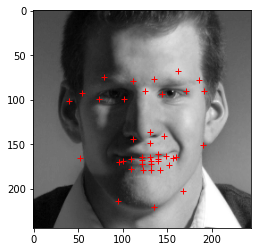

In [ ]:
def high_edge_model_pred_on_examples(img_index = 0):
  pred_edge = model_edge_high.predict(examples_edge_high[img_index].reshape(1,-1))
  #visualise_pts_and_pred(x_test[img_index], y_test[img_index], pred_edge.reshape(42, 2))


  return pred_edge

list_of_pred_high_edge_on_examples = np.array([high_edge_model_pred_on_examples(x) for x in range(len(examples_edge_high))])

for i in range(len(examples_edge_high)):
  visualise_pts(examples_gray[i],list_of_pred_high_edge_on_examples[i].reshape(42, 2))

[]

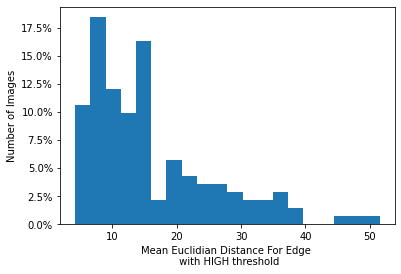

In [ ]:
#plotting all the edge euclidian distribution averages against their correspoinding image
from matplotlib.ticker import PercentFormatter
y = euc_dist_avg_all_edge_high
x = range(1, len(y)+1)
plt.ylabel("Number of Images")
plt.xlabel("Mean Euclidian Distance For Edge \n with HIGH threshold")
plt.hist(y,bins=20,weights=np.ones(len(y)) / len(y))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.plot()

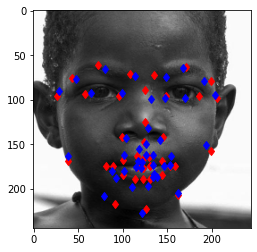

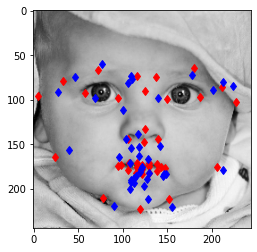

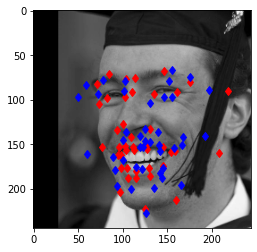

In [ ]:
#shows a sample of predictions for pictures.
for i in range(3):
  visualise_pts_and_pred(x_test[i],y_test[i], list_of_pred_edge_high[i].reshape(42, 2))

# Edge LOW

In [ ]:
from sklearn.linear_model import LinearRegression
#training a linear regression model for a canny edge set of images at a 75 and 150 threshold
model_edge_low = LinearRegression()


model_edge_low.fit(x_train_edge_low,y_train_edge_low)

LinearRegression()

(<matplotlib.axes._subplots.AxesSubplot at 0x7f4bc922cb50>,
 <matplotlib.image.AxesImage at 0x7f4bc0d0c5d0>)

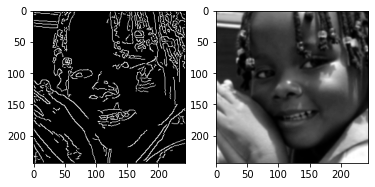

In [ ]:
plt.subplot(121),plt.imshow(x_train_edge_low[0].reshape((244,244)),cmap = 'gray')
plt.subplot(122),plt.imshow(x_train_edge_low_blur[0],cmap = 'gray')

In [ ]:
def edge_model_pred_low(img_index = 0):
  pred_edge = model_edge_low.predict(x_test_edge_low[img_index].reshape(1,-1))
  #visualise_pts_and_pred(x_test[img_index], y_test[img_index], pred_edge.reshape(42, 2))
  return pred_edge

list_of_pred_edge_low = np.array([edge_model_pred_low(x) for x in range(len(x_test))])
euc_dist_avg_all_edge_low = np.array([np.mean(euclid_dist(list_of_pred_edge_low[i].reshape(42, 2),y_test[i].reshape(42, 2))) for i in range(len(y_test))])


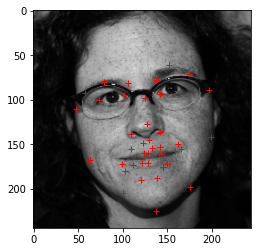

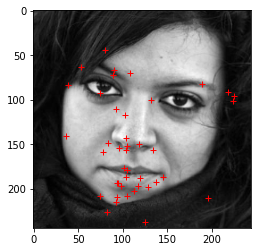

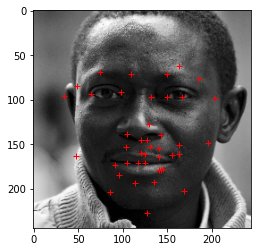

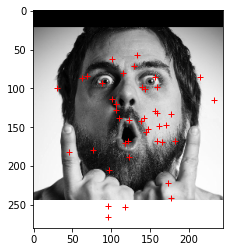

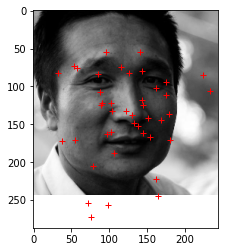

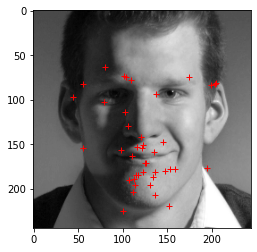

In [ ]:
def low_edge_model_pred_on_examples(img_index = 0):
  pred_edge = model_edge_low.predict(examples_edge_low[img_index].reshape(1,-1))
  #visualise_pts_and_pred(x_test[img_index], y_test[img_index], pred_edge.reshape(42, 2))


  return pred_edge

list_of_pred_low_edge_on_examples = np.array([low_edge_model_pred_on_examples(x) for x in range(len(examples_edge_low))])

for i in range(len(examples_edge_low)):
  visualise_pts(examples_gray[i],list_of_pred_low_edge_on_examples[i].reshape(42, 2))

[]

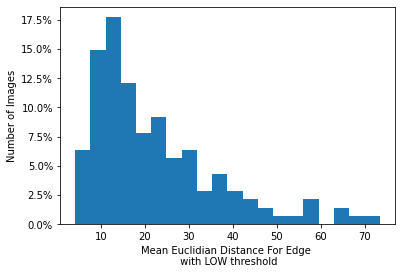

In [ ]:
#plotting all the edge euclidian distribution averages against their correspoinding image
from matplotlib.ticker import PercentFormatter
y = euc_dist_avg_all_edge_low
x = range(1, len(y)+1)
plt.ylabel("Number of Images")
plt.xlabel("Mean Euclidian Distance For Edge \n with LOW threshold")
plt.hist(y,bins=20,weights=np.ones(len(y)) / len(y))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.plot()

In [ ]:
print(max(euc_dist_avg_all_edge_low),min(euc_dist_avg_all_edge_low),np.mean(euc_dist_avg_all_edge_low))

73.37119414617803 4.190990777114904 22.212742456145527


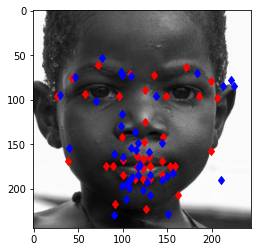

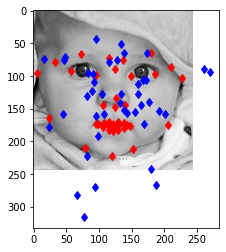

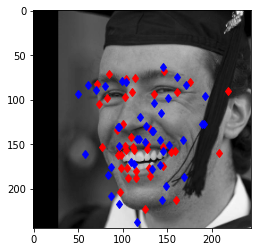

In [ ]:
#shows a sample of predictions for pictures.
for i in range(3):
  visualise_pts_and_pred(x_test[i],y_test[i], list_of_pred_edge_low[i].reshape(42, 2))

# Flattening an image


In [ ]:
from sklearn.linear_model import LinearRegression
#training a linear regression model for a flat set of images
model_flat = LinearRegression()
model_flat.fit(x_train_flat, y_train_flat)


LinearRegression()

In [ ]:
#getting the prediction of an image using model trained with flat
def flat_model_pred(img_index = 0):
  pred_flat = model_flat.predict(x_test_flat[img_index].reshape(1,-1))
  #visualise_pts(x_test[img_index], pred_flat.reshape(42, 2))
  return pred_flat

list_of_pred_flat = [flat_model_pred(x) for x in range(len(x_test_flat))]
euc_dist_avg_all_flat = [np.mean(euclid_dist(list_of_pred_flat[i].reshape(42, 2),y_test[i].reshape(42, 2))) for i in range(len(y_test))]
#euclid_dist(pred_flat.reshape(42, 2),y_test[2].reshape(42, 2))

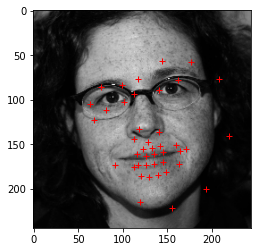

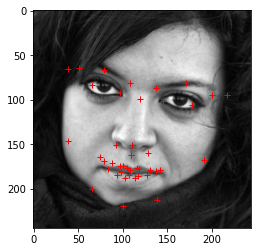

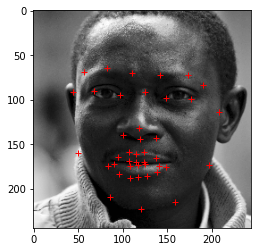

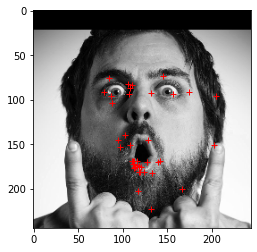

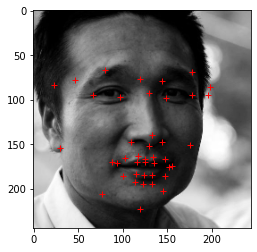

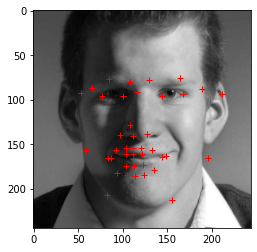

In [ ]:
def flat_model_pred_on_examples(img_index = 0):
  pred_edge = model_flat.predict(examples_flat[img_index].reshape(1,-1))
  #visualise_pts_and_pred(x_test[img_index], y_test[img_index], pred_edge.reshape(42, 2))


  return pred_edge

list_of_pred_flat_on_examples = np.array([flat_model_pred_on_examples(x) for x in range(len(examples_flat))])

for i in range(len(examples_flat)):
  visualise_pts(examples_gray[i],list_of_pred_flat_on_examples[i].reshape(42, 2))

[]

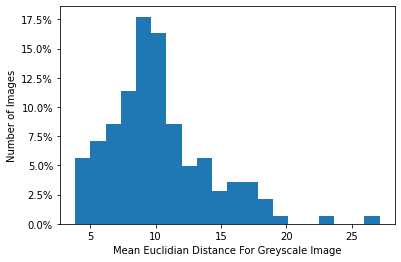

In [ ]:
#plotting all the flat euclidian distribution averages against their correspoinding image
from matplotlib.ticker import PercentFormatter
y = euc_dist_avg_all_flat
x = range(1, len(y)+1)
plt.ylabel("Number of Images")
plt.xlabel("Mean Euclidian Distance For Greyscale Image")
plt.hist(y,bins=20,weights=np.ones(len(y)) / len(y))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.plot()

#print(np.mean(euc_dist_avg_all))

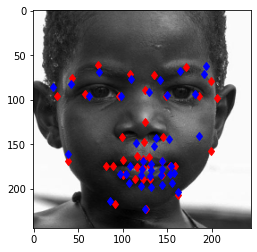

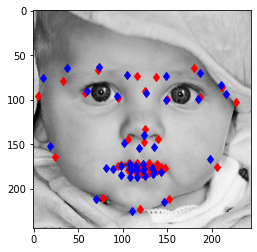

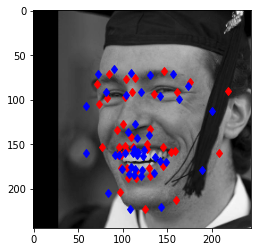

In [ ]:
#shows a sample of predictions for pictures.
for i in range(3):
  visualise_pts_and_pred(x_test[i],y_test[i], list_of_pred_flat[i].reshape(42, 2))

In [ ]:
import pandas as pd

all_binary_avs = [min(euc_dist_avg_all_binary),max(euc_dist_avg_all_binary),np.mean(euc_dist_avg_all_binary)]
all_binary_ad_avs = [min(euc_dist_avg_all_binary_ad),max(euc_dist_avg_all_binary_ad),np.mean(euc_dist_avg_all_binary_ad)]
all_flat = [min(euc_dist_avg_all_flat),max(euc_dist_avg_all_flat),np.mean(euc_dist_avg_all_flat)]
all_hog = [min(euc_dist_avg_all_hog),max(euc_dist_avg_all_hog),np.mean(euc_dist_avg_all_hog)]
all_edge_high = [min(euc_dist_avg_all_edge_high),max(euc_dist_avg_all_edge_high),np.mean(euc_dist_avg_all_edge_high)]
all_edge_low = [min(euc_dist_avg_all_edge_low),max(euc_dist_avg_all_edge_low),np.mean(euc_dist_avg_all_edge_low)]


df1 = pd.DataFrame(all_binary_avs,index=["min","max","mean"],columns=["binary fixed threshold"])
df2 = pd.DataFrame(all_binary_ad_avs,index=["min","max","mean"],columns=["binary adaptive threshold"])
df3 = pd.DataFrame(all_flat,index=["min","max","mean"],columns=["greyscale"])
df4 = pd.DataFrame(all_hog,index=["min","max","mean"],columns=["hog"])
df6 = pd.DataFrame(all_edge_high,index=["min","max","mean"],columns=["edge high threshold"])
df7 = pd.DataFrame(all_edge_low,index=["min","max","mean"],columns=["edge low threshold"])

df = pd.concat([df1,df2,df3,df4,df6,df7],axis=1)
display(df)

binary fixed threshold  binary adaptive threshold  greyscale        hog  \
min                 3.840623                   3.496394   3.859422   4.875832   
max                32.679945                  25.083864  27.114600  26.140928   
mean               10.466442                  10.389204  10.254026  11.084591   

      edge high threshold  edge low threshold  
min              4.206824            4.190991  
max             51.522385           73.371194  
mean            15.878319           22.212742